### Primer Entrenamiento

In [7]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from skimage.io import imread
import torch
import pandas as pd
from glob import glob

class MSNITDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = imread(self.images[idx])
        return torch.from_numpy(img), self.labels[idx]
    
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, path, batch_size):
        super().__init__()
        self.path = path
        self.batch_size = batch_size
    def generate_df(self, l1, l2):
        return pd.DataFrame({
            'image': l1 + l2, 
            'label': [1] * len(l1) + [0] * len(l2),
        })
    
    def setup(self, stage = None):
        train_3 = glob( str(self.path / 'train' / '3' / '*.png') )
        train_no3 = glob( str(self.path /'train' / 'no3' / '*.png') )
        self.train_df = self.generate_df(train_3, train_no3)
        
        test_3 = glob( str(self.path / 'test' / '3' / '*.png') )
        test_no3 = glob( str(self.path / 'test' / 'no3' / '*.png') )
        self.test_df = self.generate_df(test_3, test_no3)

        self.train_ds = MSNITDataset(self.train_df.image.values, self.train_df.label.values)
        self.test_ds = MSNITDataset(self.test_df.image.values, self.test_df.label.values)

    def train_dataloader(self):
        return DataLoader( self.train_ds, shuffle = True, batch_size = self.batch_size )
    
    def val_dataloader( self, batch_size = None, shuffle = False ):
        return DataLoader(
            self.test_ds, 
            batch_size = self.batch_size if batch_size is None else batch_size, 
            shuffle = shuffle 
        )

In [8]:
from pathlib import Path

path = Path('dataset')

dm = MNISTDataModule( path, batch_size = 25 )
dm.setup()

imgs, labels = next( iter( dm.train_dataloader() ) )

imgs.shape, imgs.dtype, imgs.max(), imgs.min(), labels.shape

(torch.Size([25, 28, 28]),
 torch.uint8,
 tensor(255, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 torch.Size([25]))

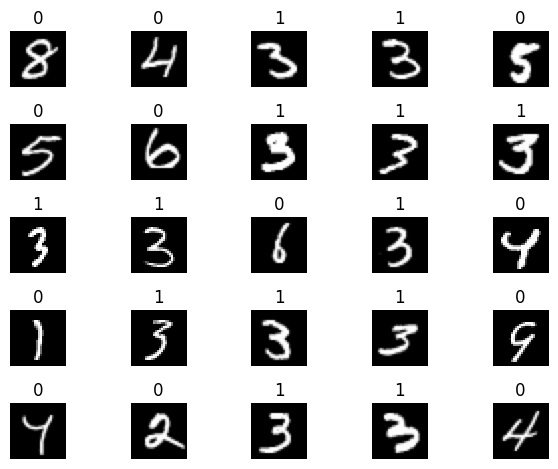

In [9]:
import matplotlib.pyplot as plt

r, c = 5, 5
fig, axs = plt.subplots( r, c )
imgs, labels = next( iter( dm.train_dataloader() ) )
for i in range ( r ):
    for j in range ( c ):
        axs[ i, j ].imshow( imgs[ i * c + j ], cmap = 'gray' )
        axs[ i, j ].set_title( labels[ i * c + j ].item() )
        axs[ i, j ].axis( 'off' )

plt.tight_layout()
plt.show()

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class MNISTModule( pl.LightningModule ):
    def __init__( self ):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear( 28 * 28, 100 ), 
            nn.ReLU(), 
            nn.Linear( 100, 1), 
        )
    
    def forward( self, x ):
        x = x.float() / 255 
        return self.mlp( x.view( x.size(0), -1 ) ).squeeze(-1)
    
    def predict( self, x ):
        self.eval()
        with torch.no_grad():
            return torch.sigmoid( self( x ) )
        
    def training_step( self, batch, batch_idx ):
        x, y = batch
        y_hat = self( x )
        loss = F.binary_cross_entropy_with_logits( y_hat, y.float() )
        preds = torch.sigmoid( y_hat ) > 0.5 
        acc = ( preds.long() == y ).float().mean()
        self.log( 'acc', acc, prog_bar = True )
        return loss
    
    def validation_step( self, batch, batch_idx ):
        x, y = batch
        y_hat = self( x )
        loss = F.binary_cross_entropy_with_logits( y_hat, y.float() )
        preds = torch.sigmoid( y_hat ) > 0.5
        acc = ( preds.long() == y ).float().mean()
        self.log( 'val_loss', loss, prog_bar = True )
        self.log( 'val_acc', acc, prog_bar = True )

    def configure_optimizers( self ):
        return torch.optim.Adam( self.parameters() )


In [11]:
module = MNISTModule()
module

MNISTModule(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [12]:
output = module(imgs)
output.shape

torch.Size([25])

In [13]:
dm = MNISTDataModule( path, batch_size = 25 )
module = MNISTModule()
trainer = pl.Trainer(
    max_epochs = 10, 
    logger = None, 
    enable_checkpointing = False, 
    # overfit_batches = 1, 
)
trainer.fit( module, dm )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/xamanek/.virtualenvs/DLops/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/xamanek/.virtualenvs/DLops/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/xamanek/.virtualenvs/DLops/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/xamanek/.virtualenvs/DLops/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 9: 100%|██████████| 7/7 [00:00<00:00, 72.81it/s, v_num=0, acc=1.000, val_loss=0.0944, val_acc=0.975]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 7/7 [00:00<00:00, 72.02it/s, v_num=0, acc=1.000, val_loss=0.0944, val_acc=0.975]


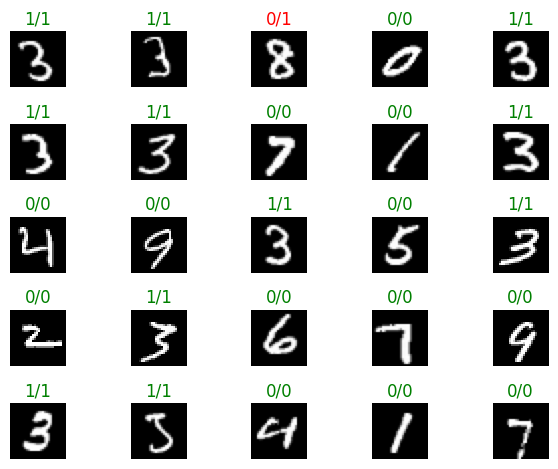

In [14]:
r, c = 5, 5
fig, axs = plt.subplots(r, c)
imgs, labels = next( iter( dm.val_dataloader( 25, True ) ) )
preds = module.predict( imgs ) > 0.5 
for i in range( r ):
    for j in range( c ):
        axs[ i, j ].imshow( imgs[ i * c + j ], cmap = 'gray' )
        label = labels[ i * c + j ].item()
        pred = preds[ i * c + j ].long().item() 
        axs[ i, j ].set_title( f'{label}/{pred}', color = 'green' if label == pred else 'red' )
        axs[ i, j ].axis( 'off' )

plt.tight_layout()
plt.show()
